/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


Sound Information:
Number of Samples: 21772800
Hertz: 22050 Hz
Seconds: 987.4285714285714 seconds


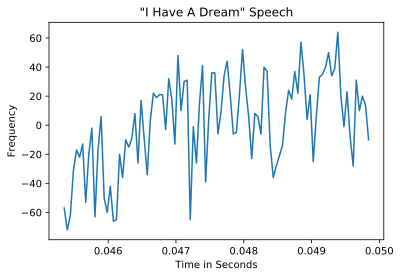

(1000000, 100)


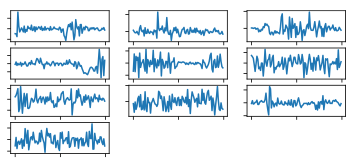

In [2]:
# importing necessary packages 

import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import wave
import sys
from scipy import signal
from sklearn.decomposition import FastICA

# making sure everything prints in iPython

%matplotlib inline

# Vector
%config InlineBackend.figure_format = 'svg'

# opening the sound file

#spf = wave.open('bark.wav','r')
#spf = wave.open('bear.wav','r')
#spf = wave.open('bird.wav','r')
#spf = wave.open('horse.wav','r')

spf = wave.open('dream.wav','r')

#spf = wave.open('ihaveadream.wav','r')

# extract raw audio from .wav file

signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
fs = spf.getframerate()

# basic information printed 
print('Sound Information:')
print('Number of Samples:', len(signal))
print('Hertz: %s Hz' % (fs))
print('Seconds: %s seconds' %(len(signal)/fs))

Time=np.linspace(0, len(signal)/fs, num=len(signal))

# plot figure

num_samples = len(signal)
plt.figure(1)


# titles

# plt.title('Birds Chirping')

plt.title('"I Have A Dream" Speech')

plt.xlabel('Time in Seconds')
plt.ylabel('Frequency')

start = 1000 #800
width = 100 #100

plt.plot(Time[start:start+width],signal[start:start+width])

# plt.savefig("bear.pdf")
# plt.savefig("bird.pdf")
plt.savefig("dream.pdf")
#plt.savefig("ihaveadream.pdf")
# plt.plot(Time, signal)

# show figure

plt.show()


# making a matrix -- features by samples

num_clips = 1000000
ds_rate = 90 #90 best option, even 85, 95 didn't work well
audio_clips = np.zeros((num_clips,width))
for i in range(num_clips):
    x_start = np.random.randint(0,num_samples-ds_rate*width)
    audio_clips[i,:] = signal[x_start:x_start+ds_rate*width:ds_rate] #end?

print(audio_clips.shape)
    
# show individual components

plt.figure()
cnt = 0
for start in range(1000,16000,1500):
    cnt += 1
    #plt.subplot(4,4,cnt)
    plt.subplot(6,3,cnt)
    frame = pylab.gca()
    frame.axes.get_xaxis().set_ticklabels([])
    frame.axes.get_yaxis().set_ticklabels([])
    plt.plot(range(width),audio_clips[cnt,:])
#plt.savefig("indvComp.pdf")
plt.savefig("indvCompdream.pdf")


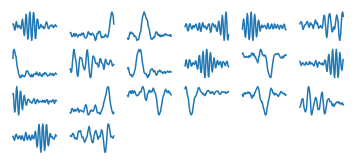

In [3]:
import sklearn.decomposition as decomposition

def icaComponents(array, components=20):
    icatemp = decomposition.FastICA(n_components=components)
    return icatemp.fit(array).components_

icacomp = icaComponents(audio_clips)

plt.figure()
cnt = 0
for cnt in range(20):
    plt.subplot(6,6,cnt+1)
    frame = pylab.gca()
    frame.axes.get_xaxis().set_ticklabels([])
    frame.axes.get_yaxis().set_ticklabels([])
    plt.axis("off")
    plt.plot(range(width),icacomp[cnt,:])
    
    plt.savefig('dreamfilters.pdf')
    #plt.savefig('ihaveadreamfilters.pdf')

mean before centering: 0.000162429399183
mean after centering: 1.62630325873e-19


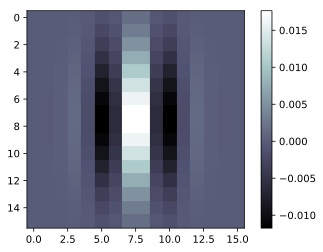

In [4]:
import numpy as np
import pylab as py
import math

#show plots in the notebook
%matplotlib inline
py.bone()

#Gabor helper function
def gaborCalc(x, y, sx, sy, fx, fy):
    p1 = (1/(2*math.pi*sx*sy))
    p2 = math.exp(-0.5*(((x*x)/(sx*sx))+((y*y)/(sy*sy))))
    p3 = math.cos(2*math.pi*(fx*x+fy*y))
    return p1 * p2 * p3

def gaborFilter(sizeX = 16, sizeY = 16, sx = 2.0, sy = 3.5, fx = 0.2, fy = 0.0):
    return [[gaborCalc(x-7.5,y-7.5,sx,sy,fx,fy) for x in range(sizeX)] for y in range(sizeY)]

gabor_filter = gaborFilter()

print('mean before centering:',np.mean(gabor_filter))
gabor_filter = np.array(gabor_filter)
pos_ind = gabor_filter >= 0
neg_ind = gabor_filter < 0
pos_sum = np.sum(gabor_filter[pos_ind])
neg_sum = np.sum(gabor_filter[neg_ind])
gabor_filter[neg_ind] = - pos_sum / neg_sum * gabor_filter[neg_ind]
gabor_filter = list(gabor_filter)
print('mean after centering:',np.mean(gabor_filter))

py.imshow(gabor_filter)
py.colorbar()

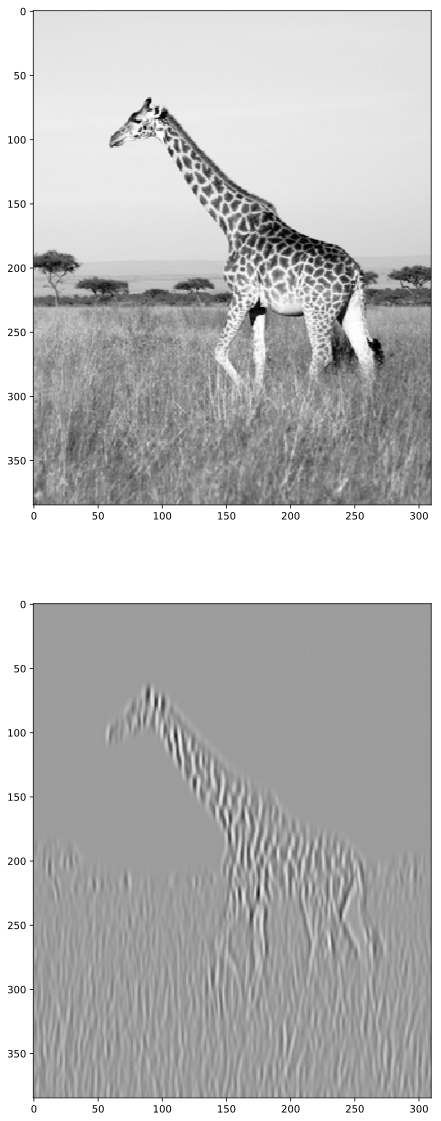

In [5]:
import matplotlib.image as mpimg

#img = mpimg.imread('images/11.tiff')
#img = mpimg.imread('images/14.tiff')
#img = mpimg.imread('images/15.tiff')
img = mpimg.imread('images/16.tiff')

# show the image
fig = py.figure(figsize=(18,20))
fig.add_subplot(2,1,1)
py.imshow(img, cmap=py.cm.Greys_r)

from scipy import ndimage


#Convolve with the Gabor filter
#img_gabor = ndimage.convolve(img, gabor_filter, mode='reflect', cval=0.0)
img_gabor = ndimage.convolve(img.astype(float), gabor_filter, mode='reflect', cval=0.0)
fig.add_subplot(2,1,2)
py.imshow(img_gabor, cmap=py.cm.Greys_r)
fig.savefig("pic16_withfilter.pdf")

In [6]:
def collect_natural_patches(img_folder, num_patches = 5000, patch_width = 8, downsample=2):
  """ collects image patches, in the same way as the LGN model, for analysis 
  the natural images are from a specific folder of .tiff files"""

  from PIL import Image
  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0
  try_cnt = 0
  ds = downsample
  w = patch_width * ds
  d = w * w
  d_final = patch_width * patch_width
  avg_filt = np.ones([ds, ds],'float') / ds**2

  layer_patch = np.zeros([1,w,w],float)
  down_patch = np.zeros([1,patch_width,patch_width],'float')  
  patch = np.zeros([d,1],float)
  
  img_patches = np.zeros( [d_final,num_patches],float)

  # change the image sampled from
  nat_img_cnt = 1  
  active = Image.open(img_folder + '/' + str(nat_img_cnt) + '.tiff')
  active = np.asarray(active, 'double').transpose()  
  # normalizing the activity image
  active -= active.mean()
  active /= active.std()
      
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > 50000 or \
      (patch_cnt - img_first_patch) > num_patches/12:
      # change the image sampled from
      nat_img_cnt += 1
      active = Image.open(img_folder + '/' + str(nat_img_cnt) + '.tiff')
      active = np.asarray(active, 'double').transpose()        
      # normalizing the activity image
      active -= active.mean()
      active /= active.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
      print (float(patch_cnt)/num_patches)
    
    px = np.random.randint(0,image_width - w)
    py = np.random.randint(0,image_width - w)
        
    layer_patch[0,:,:] = active[px:px+w,py:py+w].copy()
    patch_std = layer_patch.std()
    
    if patch_std > 0.0:
      # create the patch vector
      # downsample the patch
      for x in range(patch_width):
        for y in range(patch_width):
          down_patch[0,x,y] = np.sum(avg_filt * layer_patch[0,ds*x:ds*x+ds,ds*y:ds*y+ds])      
      patch = np.reshape(down_patch, d_final)     
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat = collect_natural_patches('images', num_patches=50000)
print(patches_mat.shape)

0.08334
0.16668
0.25002
0.33336
0.4167
0.50004
0.58338
0.66672
0.75006
0.8334
0.91674
(64, 50000)


In [7]:
def show_patches_mat(pre_patches, show_patch_num = 16, display=True, num_layers=1):
  """ this function generates a 2D array to display image patches """

  patches = pre_patches
    
  tot_patches = patches.shape[1]
  data_dim = patches.shape[0]
  patch_width = np.sqrt(data_dim / num_layers)
  
  # extract show_patch_num patches
  disp_patch = np.zeros([data_dim, show_patch_num], float)
  for i in range(0,show_patch_num):
    #if i < 5:
      # the first 5 patches
      #patch_i = i
    #elif i < 10:
      # spread the samples in the middle
    patch_i = i * tot_patches // show_patch_num
    #else:
      # the last 5 patches
      #patch_i = tot_patches - (show_patch_num - i)
  
    patch = patches[:,patch_i].copy()
    pmax  = patch.max()
    pmin = patch.min()
    # fix patch range from min to max to 0 to 1
    if pmax > pmin: 
      patch = (patch - pmin) / (pmax - pmin)
    disp_patch[:,i] = patch.copy()

  bw = 5    # border width
  pw_y = patch_width
  pw_x = patch_width * num_layers + (num_layers-1)*bw
  
  patches_y = int(np.sqrt(show_patch_num))
  patches_x = int(np.ceil(float(show_patch_num) / patches_y))
  patch_img = disp_patch.max() * np.ones([(pw_x + bw) * patches_x - bw,
    patches_y * (pw_y + bw) - bw], float)
  for i in range(0,show_patch_num): 
    y_i = int(i / patches_y)
    x_i = i % patches_y
    reshaped = disp_patch[:,i].reshape((num_layers,patch_width,patch_width))
    full_patch = np.zeros([pw_x, pw_y], float)
    full_patch[0:patch_width,:] = reshaped[0,:,:].copy()
    if num_layers == 2:
      full_patch[patch_width + bw - 1:2 * patch_width + bw, :] = reshaped[1,:,:].copy()
    patch_img[x_i*(pw_x+bw):x_i*(pw_x+bw)+pw_x,y_i*(pw_y+bw):y_i*(pw_y+bw)+pw_y] = full_patch
  
  if display:
    py.bone()
    py.imshow(patch_img.T, interpolation='nearest')
    py.axis('off')
  return patch_img

show_patches_mat(patches_mat)

py.savefig('patches.pdf')

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
# finding PCA components

from math import sqrt
from sklearn import decomposition

#Convert 256x arrays back to 16x16 arrays

def delinearize(array):
    size = sqrt(len(array))
    outarray = []
    temp = []
    counter = 1
    for i in range(len(array)):
        if size != counter:
            temp.append(array[i])
            counter += 1
        else:
            outarray.append(temp)
            temp=[]
            counter=1
    return outarray

def pcaComponents(array, components=10):
    pcatemp = decomposition.PCA(n_components=components)
    pcafit = pcatemp.fit(array)
    print(pcafit.explained_variance_ratio_)   
    return pcafit.components_

num_components = 20
pcacomp = pcaComponents(np.transpose(patches_mat), components = num_components)

fig = py.figure(figsize=(16,16))
for i in range(num_components):
    fig.add_subplot(np.ceil(num_components/5),5,i+1)
    py.imshow(delinearize(pcacomp[i]))
    py.axis("off")
    
py.savefig('patches2.pdf')

In [ ]:
def icaComponents(array, components):
    icatemp = decomposition.FastICA(n_components=components)
    return icatemp.fit(array).components_

#num_components = 10
num_components = 50
icacomp = icaComponents(np.transpose(patches_mat), components = num_components)

print(icacomp.shape)
fig = py.figure(figsize=(25,25))
for i in range(num_components):
    fig.add_subplot(np.ceil(num_components/10),5,i+1) 
    #fig.add_subplot(np.ceil(num_components/5),5,i+1) 
    py.imshow(delinearize(icacomp[i]))
    py.axis("off")
    py.savefig('patches3.pdf')